## Learning to reinforcement learn.

https://arxiv.org/abs/1611.05763

For now, reproduce the independent bandits experiments.

In [1]:
import numpy as np
import tensorflow as tf
import trfl

import tensorflow_probability as tfp
tfd = tfp.distributions
tf.enable_eager_execution()

import matplotlib.pyplot as plt

In [2]:
class Env():
    """
    A super simple environment to play with.
    A multi-armed bandit.
    """
    def __init__(self, n_bandits, maxsteps=100):
        self.n_bandits = n_bandits
        self.means = np.random.standard_normal(n_bandits)
        self.stddev = np.abs(np.random.standard_normal(n_bandits))
        
        self.reset()
        self.maxsteps = maxsteps
        
    def step(self, action):
        reward = self.means[action] + self.stddev[action] * 0.1*np.random.standard_normal()
        
        if self.timestep >= self.maxsteps-1:
            done = True
            self.reset()
        else:
            done = False
            self.timestep += 1
            
        # NOTE is it necessary to provide x=t? or can the RNN learn to count?
        return self.timestep+1, reward, done
    
    def reset(self):
        self.timestep = 0
        return self.timestep, 0, False
    
    def show(self):
        plt.figure(figsize=(8, 4))
        plt.title('Bandit arm values')
        plt.bar(range(self.n_bandits), self.means, 0.5, yerr=self.stddev)
        plt.xlabel('Arms')
        plt.ylabel('Payoff')

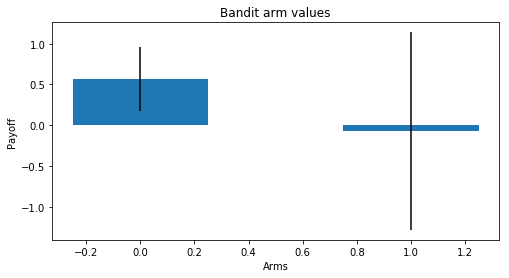

In [3]:
n_arms = 2
bandit = Env(n_arms)
bandit.show()

In [4]:
def play_episode(player, env, is_training):
    obs, r, done = env.reset()
    rewards = []
    while not done:
        a = player(obs, r, done, is_training)
        obs, r, done = env.step(a)
        rewards.append(r)
    a = player(obs, r, done)
    return rewards

def eval_player(env, player, n_episodes, is_training=True):
    """
    Args:
        env: must have a callable env.step fn that takes [state x action)s and returns (new_state, reward)
        player: a callable fn that returns actions given the current state
    """
    R = []
    for i in range(n_episodes):

        rs = play_episode(player, env, is_training)
        r = np.mean(rs)
        R.append(r)

        print('\rStep: {}, r: {}'.format(i, r), end='', flush=True)

    return R

In [5]:
"""
Want to baseline agaisnt a simple UCB learner (with hparam tuning).
"""
def softmax(x):
    return np.exp(x)/np.sum(np.exp(x))

class UCB():
    def __init__(self, action_space):
        self.action_space = action_space
        self.n_actions = len(self.action_space)

        self.lr = 0.1
        self.reset()

    def choose_action(self, s):
        s = 0
        # Hoeffding
        util = self.vals + 1/np.sqrt(self.counts+1)  # utility = exploit + explore
        p = softmax(util)
        a = np.random.choice(self.action_space, p=p)

        self.counts[a] += 1

        return a
    
    def __call__(self, s, r, done, *args):
        a = self.choose_action(s)
        
        if np.sum(self.counts)>1 and not done:
            self.train_step(self.old_a, r)
                
        # loop past actions so we can use them for training
        self.old_a = a
        
        if done:
            self.reset()
                
        return a
    
    def train_step(self, old_a, r):
        delta =  r - self.vals[old_a]  # target - estimate
        self.vals[old_a] += self.lr * delta  # incremental update. exp avg/GD!
        
    def reset(self):
        self.vals = np.zeros([self.n_actions])
        self.counts = np.zeros([self.n_actions])
    
        self.old_a = None
        self.old_r = None

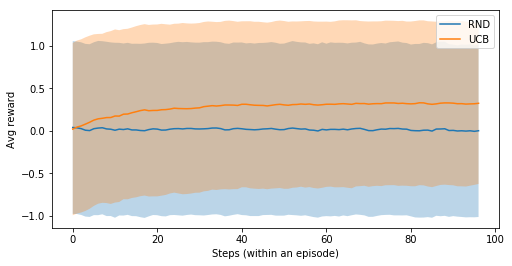

In [6]:
def plot_T(player, name):
    # the reward as a fn of episode length
    # averaged over many episodes -> want to see A2C with various amount of training.
    rs = np.vstack([play_episode(env=Env(np.random.randint(2, 10)), player=player, is_training=False) 
                    for _ in range(2000)])
    # NOTE sometimes UCB does worse than random!?!?!? if you set env = constant_bandit you should see this

    mean = np.mean(rs, axis=0)
    stddev = np.sqrt(np.var(rs,axis=0))

    # smoothing
    n_kernel = 3
    kernel = [1]*n_kernel
    mean = np.convolve(mean, kernel)[n_kernel:len(mean)]/n_kernel
    stddev = np.convolve(stddev, kernel)[n_kernel:len(stddev)]/n_kernel

    
    plt.plot(range(len(mean)), mean, label=name)
    plt.fill_between(range(len(mean)), mean-stddev, mean+stddev,  alpha=0.3)
    
    
plt.figure(figsize=(8, 4))
player = lambda *x: np.random.randint(0, n_arms)
plot_T(player, 'RND')

player = UCB(range(n_arms))
plot_T(player, 'UCB')
plt.xlabel('Steps (within an episode)')
plt.ylabel('Avg reward')
plt.legend()

Step: 499, r: 0.29301814138600624

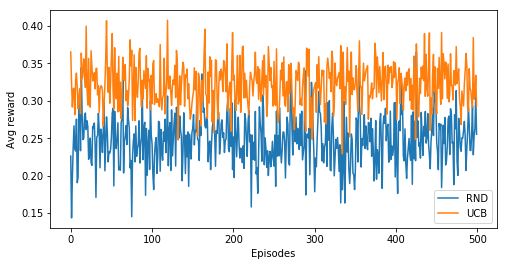

In [7]:
# How does accuracy scale with the number of episodes? it doesnt...
# K = number of episodes

# need to average over?!
player = lambda *x: np.random.randint(0, n_arms)
rnd_regrets = eval_player(bandit, player, 500)

player = UCB(range(n_arms))
ucb_regrets = eval_player(bandit, player, 500)

plt.figure(figsize=(8, 4))

plt.plot(rnd_regrets, label='RND')
plt.plot(ucb_regrets, label='UCB')

plt.xlabel('Episodes')
plt.ylabel('Avg reward')
plt.legend()

# does not improve over many episodes.

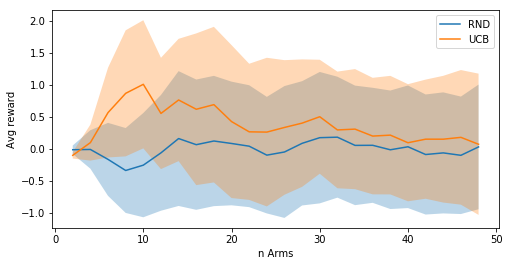

In [8]:
def plot_N(player_spec, name):
    # TODO what about how it scales with the number of actions!?
    means = []
    stddevs = []
    
    idx = range(2, 50, 2)
    for n_arms in idx:
        bandit = Env(n_arms)
        player = player_spec(n_arms)
        rs = np.vstack([play_episode(env=bandit, player=player, is_training=False) for _ in range(250)])

        means.append(np.mean(rs[:,-10:]))  # only the last few time steps
        stddevs.append(np.sqrt(np.var(rs[:,-10:])))

    mean = np.array(means)
    stddev = np.array(stddevs)
    
    # smoothing
    n_kernel = 3
    kernel = [1]*n_kernel
    mean = np.convolve(mean, kernel)[:len(mean)]/n_kernel
    stddev = np.convolve(stddev, kernel)[:len(stddev)]/n_kernel

    plt.plot(idx, mean, label=name)
    plt.fill_between(idx, mean-stddev, mean+stddev,  alpha=0.3)
    
    
plt.figure(figsize=(8, 4))

player = lambda n_arms: (lambda *x: np.random.randint(0, n_arms))
plot_N(player, 'RND')

player = lambda n_arms: UCB(range(n_arms))
plot_N(player, 'UCB')

plt.xlabel('n Arms')
plt.ylabel('Avg reward')
plt.legend()

In [9]:
# NOTE just had the thought
# we have 3 different types of memory here. 
# episodic/long term like - Memory()
# working/short term like - the state of the RNN()
# skills/?! - the parameters

def discrete_reparam(x):
    return tfd.OneHotCategorical(logits=x).sample()

class Memory():
    def __init__(self):
        self.mem = {}
        self.counter = 0
    
    def append(self, x):
        self.mem[self.counter] = x
        self.counter += 1
            
    def get_batch(self, batch_size):
        idxs = np.random.randint(0,self.size, batch_size)
        batch = [self.mem[idx] for idx in idxs]  # a list of [[obs_s, a_s, r_s], ...]
        return [np.stack(arr, axis=0) for arr in zip(*batch)]
    
    @property
    def size(self):
        return len(self.mem)

class RNN():
    """
    Handles sharing parameters between worker and learner RNNs.
    Need to be able to run the RNN for next step prediction, and end to end training.
    """
    def __init__(self, n_hidden, batch_size):
        self.cell = tf.nn.rnn_cell.MultiRNNCell([
            tf.nn.rnn_cell.LSTMCell(n_hidden),
            tf.nn.rnn_cell.LSTMCell(n_hidden)
        ])
        self.reset_state(batch_size)
        self.variables = self.cell.variables

    def __call__(self, x):   
        ys = []
        for t in range(x.shape[1]):
            y, self.state = self.cell(x[:, t, :], state=self.state)
            ys.append(y)
        return ys
    
    def step(self, x, state):
        return self.cell(x, state=state) 
    
    def reset_state(self, batch_size):
        self.state = self.cell.zero_state(batch_size=batch_size, dtype=tf.float32)
        return self.state

class Worker():
    def __init__(self, learner, batch_size):
        self.buffer = Memory()
        self.trajectory = []
        
        self.learner = learner
        self.batch_size = batch_size
        
        self.old_x = 0.0
        self.old_a = 0.0
    
    def __call__(self, x, r, done, is_training=True):
        if x is None:
            x = 0
        # call policy and take action
        a, _ = self.learner(x, self.old_a, r)
        
        if is_training:
            # add experience to buffer
            if done:
                self.buffer.append([np.stack(arr, axis=0) for arr in zip(*self.trajectory)])
                self.trajectory = []
            else:
                # obs_t, action_t -> reward_t
                self.trajectory.append([self.old_x, self.old_a, r])

            self.old_x = x
            self.old_a = a.numpy()

            # train
            if self.buffer.size > self.batch_size and done:
                # runs a training step every episode
                self.learner.train_step(*self.buffer.get_batch(self.batch_size))
            
        return a

class A2C():
    """
    Advantage actor critic
    """
    def __init__(self, n_actions, time_steps, batch_size):
        self.n_actions = n_actions
        self.batch_size = batch_size
        self.time_steps = time_steps
        
        self.rnn = RNN(64, batch_size=batch_size)
        self.nn = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation=tf.nn.selu),
            tf.keras.layers.Dense(n_actions+1)
        ])
        
        # state and action for online calls - maybe could be manage by the worker?
        self.state = self.rnn.reset_state(1)
        self.a_old = tf.constant(0, shape=[1, 1], dtype=tf.float32)
        
        self.opt = tf.train.AdamOptimizer(1e-2)
        self.global_step = tf.train.get_or_create_global_step()
        
        self.writer = tf.contrib.summary.create_file_writer('/tmp/A2C/0')
        self.writer.set_as_default()
        
    def __call__(self, x, a, r):
        """
        Choose actions online. Use the current parameters to choose an action.
        Keep the state from the last choice.
        """
        # current observation/state (x), last action taken and the r from t-1.
        x = tf.constant(x, shape=[1, 1], dtype=tf.float32)
        a = tf.constant(a, shape=[1, 1], dtype=tf.float32)
        r = tf.constant(r, shape=[1, 1], dtype=tf.float32)

        inputs = tf.concat([x, a, r], axis=-1)
        h, self.state = self.rnn.step(inputs, self.state)
        
        z = self.nn(h)
        a = tf.squeeze(tf.argmax(discrete_reparam(z[..., :-1]), axis=1))
        v = z[..., -1:]
        return a, v
        
    def forward(self, inputs):
        """
        A forward function for BPTT.
        The key is that we need to be able to differentiate wrt all inputs/params.
        """
        # QUESTION how can the net explore? cannot take random actions
        # as it is a deterministic fn of its inputs.
        # it could enumerate the different actions and try each!?
        self.rnn.reset_state(self.batch_size)
        hs = self.rnn(inputs)
        # BUG gradients are not working!!! why!?
        zs = tf.stack(list(map(self.nn, hs)), axis=0)
        
        # NOTE tbh it feels kinds weird returning a, v.
        # the v is supposed to be the estimated value of the action taken?
        # sharing parameters seems unusual. need to explore further
        return zs[:, :,:self.n_actions], zs[:, :,self.n_actions:]
        
    def train_step(self, x, a, r):
        """
        Train on a batch of data.
        
        x: (B, T)
        a: (B, T)
        r: (B, T)
        """
        x = tf.constant(x, shape=[self.batch_size, self.time_steps, 1], dtype=tf.float32)
        a = tf.constant(a, shape=[self.batch_size, self.time_steps, 1], dtype=tf.float32)
        r = tf.constant(r, shape=[self.batch_size, self.time_steps, 1], dtype=tf.float32)

        # current obs, old action, old reward
        inputs = tf.concat([x[:, 1:, :], a[:, :-1:, ], r[:, :-1, :]], axis=-1)

        actions_taken = tf.transpose(tf.squeeze(tf.cast(a[:, 1:, :], tf.int32)))
        rewards_received = tf.transpose(r[:, 1:, 0])
        returns = tf.reduce_sum(rewards_received, axis=0)

        with tf.GradientTape() as tape:

            logits, v = self.forward(inputs)
            # NOTE does this loss fn correct for its off policy nature? 
            policy_loss, extra = trfl.sequence_advantage_actor_critic_loss(
                policy_logits=logits, 
                baseline_values=v[..., 0], # Q how can A2C be extended with distributional estimates of value?
                actions=actions_taken, 
                rewards=rewards_received, 
                pcontinues=tf.ones_like(rewards_received), 
                bootstrap_value=returns,
                entropy_cost=1e-4,
                lambda_=0.5
            )

            loss = tf.reduce_mean(policy_loss)

        variables = self.nn.variables+self.rnn.variables
        grads = tape.gradient(loss, variables)
        self.opt.apply_gradients(zip(grads, variables), global_step=self.global_step)
            
        with tf.contrib.summary.record_summaries_every_n_global_steps(10):
            tf.contrib.summary.scalar('loss', loss)
            tf.contrib.summary.scalar('extra/baseline_loss', tf.reduce_mean(extra.baseline_loss))
            tf.contrib.summary.scalar('extra/policy_gradient_loss', tf.reduce_mean(extra.policy_gradient_loss))
            tf.contrib.summary.scalar('extra/entropy_loss', tf.reduce_mean(extra.entropy_loss))
            tf.contrib.summary.scalar('total_R', tf.reduce_sum(r))
            tf.contrib.summary.histogram('actions', a)

Step: 499, r: 0.56448305431883347

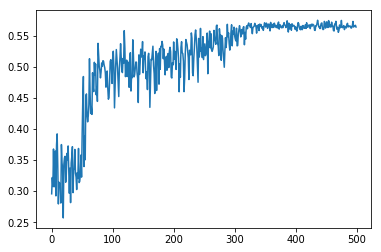

In [10]:
player = Worker(A2C(n_arms, batch_size=50, time_steps=100), 50)
regrets = eval_player(bandit, player, 500)
plt.plot(regrets)

In [ ]:
# plot_T(player, 'A2C')

# Meta learning

How can we do hparam opt for UCB? Adjusting the explore-exploit tradeoff!?

In [14]:
def eval_meta_player(player, n_episodes):
    """
    Meta learning. We give the learner a new problem to solve every time.
    We hope to see that as training progresses, the learner can solve them 'better'.
    """
  
    regrets = []
    for i in range(n_episodes):
        if i % 100 == 0:
            # "At the beginning of each episode, a new bandit task is sampled and held constant for 100 trials."
            # should that matter!?  
            # why not a new bandit every time?!
            bandit = Env(n_arms)  
        r = eval_player(env=bandit, player=player, n_episodes=1)
        r = np.mean(r)
        regrets.append(np.max(bandit.means)-r)
        print('\rStep: {}, R: {}'.format(i, regrets[-1]), end='', flush=True)

    return regrets

In [15]:
player = Worker(A2C(n_arms, batch_size=100, time_steps=100), 100)
rs = eval_meta_player(player, 5000)
plt.plot(rs)

Step: 439, R: 0.37407841451629757586

KeyboardInterrupt: 

In [ ]:
# how can you fairly evaluate this? 
# we have been training on the test data...!?

# how can you apply this to partially observable problems!?


In [ ]:
player.buffer.mem[player.buffer.counter-600]